# Objective of this notebook

### Purpose
Continuing the investigations of particle classifications, we are now moving to the classification using Convolutional Neural Network (CNN) and Residual Neural Network (ResNet). Given the results from ANN in the previous notebook, we have now known that the data of energy deposit works better on training networks rather than the data of shower features. In this notebook, we use energy deposit to train CNN and ResNet. Similar to the ANN experiments, our purpose remains to determine if the number of layers in a model depends on the model performance. 


### Outline
1. [What is CNN?](#What-is-CNN?)
    - [Define a model](#Define-a-model)
    - [Import dataset](#Import-dataset)
    - [Train CNN with shallow networks](#Train-CNN-with-shallow-networks-(2-blocks))
    - [Train CNN with deeper networks](#Train-CNN-with-deeper-model (4-blocks))
    
2. [ResNet](#What-is-ResNet?)
    - [Define a model](#Define-ResNet)
    
3. [Results](#Results)

# What is CNN?

CNN, Convolutional Neural Network, is a type of neural network architecture that extracts important features of a data and compresses them to lower dimension before passing to fully connected layers. I know it might sounds very technical, so let's go each step!

---


Neural networks can be classified into different types, which are used for different purposes. A Convolutional Neural Network (CNN) **[1]** is a Deep Learning algorithm which can take in input image and differentiate one from the other, successfully identifying patterns within an image. CNN architecture is comprised of the following main layers: convolutional layers, pooling layers, and fully connected layer. 

1. Convolutional layer "extracts" features of image, by performing convolution operation **[2]**: it computes the dot product between local regions in the input and the filter ("*kernel*"). Then it slides the kernel over the next local region repeating the same operation, until it goes through the whole image. It has ReLU activation function to make all negative value to zero. 

2. Pooling layer, used between convolutional layers, reduces the spatial volume of image after convolution, in order to avoid computationally expensive cost. 

3. Fully connected layer connects nodes in one layer to those in others to compute the "score" for each category and classify the images. 

In this way, CNN transforms the original image, layer by layer, from the original pixel values to the final class/category scores. 


*Figure*: **[1]** CNN Architecture (*left*) and **[2]** Convolution Operation (*right*)

<img src="./images/cnn.jpg" alt="CNN structure" width=60% style="float:left"/>

<img src="./images/convolution.png" alt="Convolution operation" width=34% style="float:right"/>

In [1]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pyarrow as pa
import pyarrow.parquet as pq
import glob
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import ConcatDataset,DataLoader,sampler
from sklearn.metrics import roc_curve, auc
from utils import *
import os, time
from torchshape import tensorshape
from tqdm.notebook import tqdm

Welcome to JupyROOT 6.22/06


In [2]:
plt.rcParams.update({'font.family': 'cmr10',
                     'font.size': 12,
                     'axes.unicode_minus': False,
                     'axes.labelsize': 12,
                     'axes.labelsize': 12,
                     'figure.figsize': (4, 4),
                     'figure.dpi': 160,
                     'mathtext.fontset': 'cm',
                     'mathtext.rm': 'serif',
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.top': True,
                     'ytick.right': True
                     })
plt.rcParams["axes.formatter.use_mathtext"] = True

## Define CNN model

In [13]:
## regular CNN (without residual blocks)

class ConvNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, img_dim=32):
        super().__init__()

        layers = nn.ModuleList()
        for i in range(int(num_layers)):
            layers.extend(nn.Sequential(nn.Conv2d(in_channels=1 if i==0 else hidden_dim, 
                                                  out_channels=hidden_dim, 
                                                  kernel_size=3, 
                                                  padding=1, 
                                                  stride=1),
                                    nn.ReLU(),
                                    nn.Conv2d(in_channels=hidden_dim, 
                                              out_channels=hidden_dim,
                                              kernel_size=3, 
                                              padding=1, 
                                              stride=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2)))
            
        self.layers = nn.Sequential(*layers)
        self.flatten = nn.Sequential(nn.Flatten(),
                                     nn.Linear(in_features=512 if num_layers==4 else 8192, 
                                               out_features=output_dim), 
                                     nn.Sigmoid())# use sigmoid for the last activation function as the data is binary
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        outputs = self.layers(x)
        outputs = self.dropout(outputs)
        outputs = self.flatten(outputs)
        
        return outputs
        

# Import dataset
We use the exactly same dataset that we used in ANN experiments. 

In [4]:
event_data = glob.glob('./data/Single*Pt15To100_pythia8_PU2017_MINIAODSIM.parquet.[1-8]')

# Training dataset - for optimizing net
train_set = ConcatDataset([ParquetDatasetLimitedScaled(d) for d in event_data])
idxs = np.random.permutation(len(train_set))
train_frac = 0.7  # fraction of training set to the total dataset; the rest will be used for validation
train_cut = int(train_frac*len(train_set)) 

train_sampler = sampler.SubsetRandomSampler(idxs[:train_cut])
train_loader = DataLoader(dataset=train_set, batch_size=32, num_workers=4, drop_last=True,
                          sampler=train_sampler, pin_memory=True)        

# Validation dataset - for evaluating net performance
val_set = ConcatDataset([ParquetDatasetLimitedScaled(d) for d in event_data])
val_sampler = sampler.SubsetRandomSampler(idxs[train_cut:])
val_loader = DataLoader(dataset=val_set, batch_size=32, num_workers=4, drop_last=True,
                        sampler=val_sampler)

## Training loop and evaluation loop

In [14]:
# Function to validate after training phase
val_loss, val_acc = [], []

def do_eval(model, val_loader, roc_auc_best, epoch, train_data):
    loss_, acc_ = 0., 0.
    y_pred_, y_truth_, pt_ = [], [], []
    now = time.time()
    for i, data in tqdm(enumerate(val_loader), total=len(val_loader)):
        X, y = data[train_data].to(device), data['m'].to(device) # electron/photon id stored in 'm' key
            
        logits = model(X).to(device)
        y = y.type_as(logits) # needs to be same type as logits for next line
        loss_ += F.binary_cross_entropy_with_logits(logits, y).item()
        pred = logits.ge(0.).byte()
        acc_ += pred.eq(y.byte()).float().mean().item()
        y_pred = torch.sigmoid(logits) # not used as an activation fn here; it's to map the logits to the interval [0, 1].
        # Store batch metrics:
        y_pred_.append(y_pred.tolist())
        y_truth_.append(y.tolist())


    now = time.time() - now
    y_pred_ = np.concatenate(y_pred_)
    y_truth_ = np.concatenate(y_truth_)
    s = '\n%d: Val time:%.2fs in %d steps'%(epoch, now, len(val_loader))
    print(s)
    s = '%d: Val loss:%.4f, acc:%.4f'%(epoch, loss_/len(val_loader), acc_/len(val_loader))
    print(s)

    val_loss.append(loss_/len(val_loader))
    val_acc.append(acc_/len(val_loader))
    print('Epoch: {}, Validation loss: {:.4f}, Validation accuracy: {:.4f}'.format(epoch, val_loss[epoch-1], val_acc[epoch-1]))
    
    fpr, tpr, _ = roc_curve(y_truth_, y_pred_)
    roc_auc = auc(fpr, tpr)
    s = "VAL ROC AUC: %.4f"%(roc_auc)
    print(s)

    if roc_auc > roc_auc_best:
        roc_auc_best = roc_auc
    
    return roc_auc_best, val_loss, val_acc, fpr, tpr


In [15]:
def train_CNN(model, train_data='X'):
    
    # MAIN #
    print_step = 5000
    roc_auc_best = 0.5
    print(f'training data is {train_data}')
    print(">> Training <<<<<<<<")

    # training loss and accuracy
    train_loss, train_acc = [], []
    val_best_auc = []
    total_val_loss = []
    total_val_acc = []
    total_fpr = []
    total_tpr = []

    # training loop
    for e in range(params['epoch']):

        epoch = e+1
        s = '\n>> Epoch %d <<<<<<<<'%(epoch)
        print(s)

        # Run training
        model.train()
        now = time.time()
        running_loss, running_acc = 0, 0

        for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
            X, y = data[train_data].to(device), data['m'].to(device)
            optimizer.zero_grad()
            logits = model(X).to(device)
            y = y.type_as(logits) #same type for next line
            loss = F.binary_cross_entropy_with_logits(logits, y).to(device)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            pred = logits.ge(0.).byte()
            acc = pred.eq(y.byte()).float().mean()
            running_acc += acc.item()

            if i % print_step == 0:
                pred = logits.ge(0.).byte()
                acc = pred.eq(y.byte()).float().mean()
                s = '%d: Train loss:%.4f, acc:%.4f'%(i, loss.item(), acc.item())
                print(s)

        now = time.time() - now
        s = '%d: Train time:%.2fs in %d steps'%(epoch, now, len(train_loader))
        print(s)

        train_loss.append(running_loss/len(train_loader))
        train_acc.append(running_acc/len(train_loader))
        print('Epoch: {}, Train loss: {:.4f}, Train accuracy: {:.4f}'.format(epoch, train_loss[epoch-1], train_acc[epoch-1]))

        # Run Validation
        model.eval()
        roc_auc_best, val_loss, val_acc, fpr, tpr = do_eval(model, val_loader, roc_auc_best, epoch, train_data=train_data)
        val_best_auc.append(roc_auc_best)
        total_val_loss.append(np.mean(val_loss))
        total_val_acc.append(np.mean(val_acc))
        total_fpr.append(fpr)
        total_tpr.append(tpr)
        
        lr_scheduler.step()
        
    outputs = {'train_loss':train_loss,
              'train_acc':train_acc,
              'val_best_auc':val_best_auc, # update best auc score by auc > best? 
              'val_loss': total_val_loss,
              'val_acc': total_val_acc, # simply retrieve auc scores by epoch 
              'total_fpr': total_fpr,
              'total_tpr': total_tpr}
    
    return outputs


# Train CNN with shallow networks (2 blocks)

In [17]:
# Create model with torch_resnet_single structure
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
params = {'epoch':10,
         'num_layers': 2,
         'lr':1.5e-5,
         'device':device}

cnn_model = ConvNN(input_dim=(32, 1, 32, 32), hidden_dim=128, num_layers=params['num_layers'], output_dim=1)
cnn_model = cnn_model.to(device)


optimizer = optim.Adam(cnn_model.parameters(), lr=params['lr'])
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.5)
print(summary(cnn_model, (1, 32, 32)))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           1,280
              ReLU-2          [-1, 128, 32, 32]               0
            Conv2d-3          [-1, 128, 32, 32]         147,584
              ReLU-4          [-1, 128, 32, 32]               0
         MaxPool2d-5          [-1, 128, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]         147,584
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
          Flatten-11                 [-1, 8192]               0
           Linear-12                    [-1, 1]           8,193
          Sigmoid-13                    [-1, 1]               0
Total params: 452,225
Trainable 

In [8]:
energy_outputs = train_CNN(cnn_model, train_data='X')

training data is X
>> Training <<<<<<<<

>> Epoch 1 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.6141, acc:0.7188
5000: Train loss:0.6603, acc:0.5625
10000: Train loss:0.5959, acc:0.7188
15000: Train loss:0.6599, acc:0.5938
20000: Train loss:0.5796, acc:0.5000
1: Train time:207.08s in 21215 steps
Epoch: 1, Train loss: 0.6269, Train accuracy: 0.6347

1: Val time:88.50s in 9092 steps
1: Val loss:0.6060, acc:0.6345
Epoch: 1, Validation loss: 0.6060, Validation accuracy: 0.6345
VAL ROC AUC: 0.7049

>> Epoch 2 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.6920, acc:0.5312
5000: Train loss:0.6163, acc:0.5312
10000: Train loss:0.6182, acc:0.6250
15000: Train loss:0.5877, acc:0.6250
20000: Train loss:0.6436, acc:0.5312
2: Train time:207.90s in 21215 steps
Epoch: 2, Train loss: 0.6035, Train accuracy: 0.6347

2: Val time:88.38s in 9092 steps
2: Val loss:0.6074, acc:0.6345
Epoch: 2, Validation loss: 0.6074, Validation accuracy: 0.6345
VAL ROC AUC: 0.7121

>> Epoch 3 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.6272, acc:0.5625
5000: Train loss:0.5811, acc:0.5938
10000: Train loss:0.6631, acc:0.7188
15000: Train loss:0.6030, acc:0.5625
20000: Train loss:0.5800, acc:0.6250
3: Train time:207.46s in 21215 steps
Epoch: 3, Train loss: 0.6012, Train accuracy: 0.6347

3: Val time:88.53s in 9092 steps
3: Val loss:0.5994, acc:0.6345
Epoch: 3, Validation loss: 0.5994, Validation accuracy: 0.6345
VAL ROC AUC: 0.7179

>> Epoch 4 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.5980, acc:0.5312
5000: Train loss:0.6302, acc:0.5312
10000: Train loss:0.5779, acc:0.5625
15000: Train loss:0.6149, acc:0.5625
20000: Train loss:0.5620, acc:0.7500
4: Train time:207.55s in 21215 steps
Epoch: 4, Train loss: 0.5997, Train accuracy: 0.6347

4: Val time:88.81s in 9092 steps
4: Val loss:0.5978, acc:0.6345
Epoch: 4, Validation loss: 0.5978, Validation accuracy: 0.6345
VAL ROC AUC: 0.7197

>> Epoch 5 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.6060, acc:0.5938
5000: Train loss:0.6069, acc:0.5938
10000: Train loss:0.5954, acc:0.6562
15000: Train loss:0.5966, acc:0.5625
20000: Train loss:0.6295, acc:0.5938
5: Train time:207.10s in 21215 steps
Epoch: 5, Train loss: 0.5988, Train accuracy: 0.6347

5: Val time:88.53s in 9092 steps
5: Val loss:0.5973, acc:0.6345
Epoch: 5, Validation loss: 0.5973, Validation accuracy: 0.6345
VAL ROC AUC: 0.7211

>> Epoch 6 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.5182, acc:0.7812
5000: Train loss:0.6960, acc:0.4062
10000: Train loss:0.4935, acc:0.7188
15000: Train loss:0.5372, acc:0.8750
20000: Train loss:0.6520, acc:0.6250
6: Train time:209.36s in 21215 steps
Epoch: 6, Train loss: 0.5980, Train accuracy: 0.6347

6: Val time:88.93s in 9092 steps
6: Val loss:0.6035, acc:0.6345
Epoch: 6, Validation loss: 0.6035, Validation accuracy: 0.6345
VAL ROC AUC: 0.7217

>> Epoch 7 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.5756, acc:0.6562
5000: Train loss:0.5873, acc:0.6875
10000: Train loss:0.5800, acc:0.6562
15000: Train loss:0.4980, acc:0.7812
20000: Train loss:0.6227, acc:0.5312
7: Train time:207.36s in 21215 steps
Epoch: 7, Train loss: 0.5974, Train accuracy: 0.6347

7: Val time:88.49s in 9092 steps
7: Val loss:0.5956, acc:0.6345
Epoch: 7, Validation loss: 0.5956, Validation accuracy: 0.6345
VAL ROC AUC: 0.7260

>> Epoch 8 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.5764, acc:0.5625
5000: Train loss:0.6192, acc:0.5938
10000: Train loss:0.5615, acc:0.6875
15000: Train loss:0.5359, acc:0.7188
20000: Train loss:0.6042, acc:0.5938
8: Train time:209.35s in 21215 steps
Epoch: 8, Train loss: 0.5966, Train accuracy: 0.6347

8: Val time:88.76s in 9092 steps
8: Val loss:0.5934, acc:0.6345
Epoch: 8, Validation loss: 0.5934, Validation accuracy: 0.6345
VAL ROC AUC: 0.7282

>> Epoch 9 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.5702, acc:0.6875
5000: Train loss:0.5379, acc:0.6875
10000: Train loss:0.5661, acc:0.7188
15000: Train loss:0.5249, acc:0.7500
20000: Train loss:0.5806, acc:0.6250
9: Train time:207.69s in 21215 steps
Epoch: 9, Train loss: 0.5960, Train accuracy: 0.6347

9: Val time:88.90s in 9092 steps
9: Val loss:0.5964, acc:0.6345
Epoch: 9, Validation loss: 0.5964, Validation accuracy: 0.6345
VAL ROC AUC: 0.7269

>> Epoch 10 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.6776, acc:0.5000
5000: Train loss:0.6502, acc:0.6250
10000: Train loss:0.6156, acc:0.6250
15000: Train loss:0.5078, acc:0.9062
20000: Train loss:0.6266, acc:0.5000
10: Train time:208.12s in 21215 steps
Epoch: 10, Train loss: 0.5955, Train accuracy: 0.6347

10: Val time:88.84s in 9092 steps
10: Val loss:0.5972, acc:0.6345
Epoch: 10, Validation loss: 0.5972, Validation accuracy: 0.6345
VAL ROC AUC: 0.7299


In [9]:
# save the data
train_data_directory = '../EGamma/train_data/'
np.save(file=train_data_directory + 'cnn_energy_train_loss', arr=energy_outputs['train_loss'])
np.save(file=train_data_directory + 'cnn_energy_train_acc', arr=energy_outputs['train_acc'])
np.save(file=train_data_directory + 'cnn_energy_val_best_auc', arr=energy_outputs['val_best_auc'])
np.save(file=train_data_directory + 'cnn_energy_val_loss', arr=energy_outputs['val_loss'])
np.save(file=train_data_directory + 'cnn_energy_val_acc', arr=energy_outputs['val_acc'])
np.save(file=train_data_directory + 'cnn_energy_fpr', arr=energy_outputs['total_fpr'][0], allow_pickle=True)
np.save(file=train_data_directory + 'cnn_energy_tpr', arr=energy_outputs['total_tpr'][0], allow_pickle=True)

## Train CNN with deeper model (4 blocks)

In [16]:
# Create model with torch_resnet_single structure
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
params = {'epoch':10,
         'num_layers': 4,
         'lr':1.5e-5,
         'device':device}

cnn_model = ConvNN(input_dim=(32, 1, 32, 32), hidden_dim=128, num_layers=params['num_layers'], output_dim=1)
cnn_model = cnn_model.to(device)

optimizer = optim.Adam(cnn_model.parameters(), lr=params['lr'])
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20], gamma=0.5)
print(summary(cnn_model, (1, 32, 32)))

cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           1,280
              ReLU-2          [-1, 128, 32, 32]               0
            Conv2d-3          [-1, 128, 32, 32]         147,584
              ReLU-4          [-1, 128, 32, 32]               0
         MaxPool2d-5          [-1, 128, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]         147,584
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 128, 8, 8]         147,584
             ReLU-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 128, 8, 8]         147,584
             ReLU-14            

In [17]:
energy_outputs_4_layers = train_CNN(cnn_model, train_data='X')#7 mins per epoch

training data is X
>> Training <<<<<<<<

>> Epoch 1 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.6771, acc:0.5938
5000: Train loss:0.6005, acc:0.7188
10000: Train loss:0.5912, acc:0.6562
15000: Train loss:0.6608, acc:0.5938
20000: Train loss:0.6168, acc:0.6562
1: Train time:248.96s in 21215 steps
Epoch: 1, Train loss: 0.6182, Train accuracy: 0.6347


  0%|          | 0/9092 [00:00<?, ?it/s]


1: Val time:89.53s in 9092 steps
1: Val loss:0.6011, acc:0.6345
Epoch: 1, Validation loss: 0.6011, Validation accuracy: 0.6345
VAL ROC AUC: 0.7148

>> Epoch 2 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.6329, acc:0.5625
5000: Train loss:0.5120, acc:0.6562
10000: Train loss:0.5678, acc:0.6875
15000: Train loss:0.5811, acc:0.5938
20000: Train loss:0.5519, acc:0.7188
2: Train time:211.03s in 21215 steps
Epoch: 2, Train loss: 0.6031, Train accuracy: 0.6347


  0%|          | 0/9092 [00:00<?, ?it/s]


2: Val time:90.43s in 9092 steps
2: Val loss:0.5980, acc:0.6345
Epoch: 2, Validation loss: 0.5980, Validation accuracy: 0.6345
VAL ROC AUC: 0.7187

>> Epoch 3 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.5981, acc:0.6562
5000: Train loss:0.5703, acc:0.6562
10000: Train loss:0.5365, acc:0.6562
15000: Train loss:0.6747, acc:0.6562
20000: Train loss:0.6778, acc:0.4375
3: Train time:211.54s in 21215 steps
Epoch: 3, Train loss: 0.6008, Train accuracy: 0.6347


  0%|          | 0/9092 [00:00<?, ?it/s]


3: Val time:89.85s in 9092 steps
3: Val loss:0.5961, acc:0.6345
Epoch: 3, Validation loss: 0.5961, Validation accuracy: 0.6345
VAL ROC AUC: 0.7258

>> Epoch 4 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.6160, acc:0.6250
5000: Train loss:0.5921, acc:0.6250
10000: Train loss:0.6186, acc:0.6250
15000: Train loss:0.6107, acc:0.5625
20000: Train loss:0.5847, acc:0.7812
4: Train time:211.34s in 21215 steps
Epoch: 4, Train loss: 0.5989, Train accuracy: 0.6347


  0%|          | 0/9092 [00:00<?, ?it/s]


4: Val time:90.09s in 9092 steps
4: Val loss:0.5965, acc:0.6345
Epoch: 4, Validation loss: 0.5965, Validation accuracy: 0.6345
VAL ROC AUC: 0.7291

>> Epoch 5 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.5548, acc:0.6250
5000: Train loss:0.5755, acc:0.6250
10000: Train loss:0.5401, acc:0.7500
15000: Train loss:0.6347, acc:0.5625
20000: Train loss:0.7292, acc:0.5312
5: Train time:211.74s in 21215 steps
Epoch: 5, Train loss: 0.5971, Train accuracy: 0.6347


  0%|          | 0/9092 [00:00<?, ?it/s]


5: Val time:89.63s in 9092 steps
5: Val loss:0.5993, acc:0.6345
Epoch: 5, Validation loss: 0.5993, Validation accuracy: 0.6345
VAL ROC AUC: 0.7349

>> Epoch 6 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.5515, acc:0.6875
5000: Train loss:0.6778, acc:0.5312
10000: Train loss:0.5554, acc:0.7188
15000: Train loss:0.6597, acc:0.6250
20000: Train loss:0.6911, acc:0.5312
6: Train time:212.44s in 21215 steps
Epoch: 6, Train loss: 0.5960, Train accuracy: 0.6347


  0%|          | 0/9092 [00:00<?, ?it/s]


6: Val time:91.01s in 9092 steps
6: Val loss:0.5936, acc:0.6345
Epoch: 6, Validation loss: 0.5936, Validation accuracy: 0.6345
VAL ROC AUC: 0.7369

>> Epoch 7 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.5701, acc:0.7188
5000: Train loss:0.5495, acc:0.6250
10000: Train loss:0.5496, acc:0.7188
15000: Train loss:0.5228, acc:0.7188
20000: Train loss:0.6029, acc:0.6875
7: Train time:211.80s in 21215 steps
Epoch: 7, Train loss: 0.5948, Train accuracy: 0.6347


  0%|          | 0/9092 [00:00<?, ?it/s]


7: Val time:89.78s in 9092 steps
7: Val loss:0.5927, acc:0.6345
Epoch: 7, Validation loss: 0.5927, Validation accuracy: 0.6345
VAL ROC AUC: 0.7339

>> Epoch 8 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.5234, acc:0.7188
5000: Train loss:0.6192, acc:0.7188
10000: Train loss:0.5922, acc:0.6562
15000: Train loss:0.6090, acc:0.5625
20000: Train loss:0.6676, acc:0.5312
8: Train time:211.79s in 21215 steps
Epoch: 8, Train loss: 0.5939, Train accuracy: 0.6347


  0%|          | 0/9092 [00:00<?, ?it/s]


8: Val time:90.86s in 9092 steps
8: Val loss:0.5948, acc:0.6345
Epoch: 8, Validation loss: 0.5948, Validation accuracy: 0.6345
VAL ROC AUC: 0.7350

>> Epoch 9 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.5846, acc:0.7500
5000: Train loss:0.6774, acc:0.5938
10000: Train loss:0.5065, acc:0.6562
15000: Train loss:0.6239, acc:0.6250
20000: Train loss:0.6556, acc:0.5938
9: Train time:211.97s in 21215 steps
Epoch: 9, Train loss: 0.5932, Train accuracy: 0.6347


  0%|          | 0/9092 [00:00<?, ?it/s]


9: Val time:89.75s in 9092 steps
9: Val loss:0.5923, acc:0.6345
Epoch: 9, Validation loss: 0.5923, Validation accuracy: 0.6345
VAL ROC AUC: 0.7373

>> Epoch 10 <<<<<<<<


  0%|          | 0/21215 [00:00<?, ?it/s]

0: Train loss:0.6005, acc:0.7500
5000: Train loss:0.5669, acc:0.6562
10000: Train loss:0.5966, acc:0.5312
15000: Train loss:0.5841, acc:0.7500
20000: Train loss:0.5556, acc:0.7188
10: Train time:211.84s in 21215 steps
Epoch: 10, Train loss: 0.5929, Train accuracy: 0.6347


  0%|          | 0/9092 [00:00<?, ?it/s]


10: Val time:90.48s in 9092 steps
10: Val loss:0.5909, acc:0.6345
Epoch: 10, Validation loss: 0.5909, Validation accuracy: 0.6345
VAL ROC AUC: 0.7411


In [18]:
# Save the data
train_data_directory = '../EGamma/train_data/'
np.save(file=train_data_directory + 'cnn_4_layers_energy_train_loss', arr=energy_outputs_4_layers['train_loss'])
np.save(file=train_data_directory + 'cnn_4_layers_energy_train_acc', arr=energy_outputs_4_layers['train_acc'])
np.save(file=train_data_directory + 'cnn_4_layers_energy_val_best_auc', arr=energy_outputs_4_layers['val_best_auc'])
np.save(file=train_data_directory + 'cnn_4_layers_energy_val_loss', arr=energy_outputs_4_layers['val_loss'])
np.save(file=train_data_directory + 'cnn_4_layers_energy_val_acc', arr=energy_outputs_4_layers['val_acc'])
np.save(file=train_data_directory + 'cnn_4_layers_energy_fpr', arr=energy_outputs_4_layers['total_fpr'][0], allow_pickle=True)
np.save(file=train_data_directory + 'cnn_4_layers_energy_tpr', arr=energy_outputs_4_layers['total_tpr'][0], allow_pickle=True)

In [19]:
train_data_directory = '../EGamma/train_data/'
auc_2 = np.load(train_data_directory + 'cnn_energy_val_best_auc.npy')
auc_4 = np.load(train_data_directory + 'cnn_4_layers_energy_val_best_auc.npy')
print(max(auc_2), max(auc_4))

0.7298559383112183 0.7410692206124176


# What is ResNet?

*Figure*: **[1]** Network Structure Changing with Adding layers (*left*) and **[2]** Residual Blocks (*right*)
<img src="./images/nested.png" alt="Nested function classes" width=55% style="float:left"/>

<img src="./images/resnet.png" alt="Residual Blocks" width=35% style="float:right"/>

While CNN performs a good fitting to image dataset with the reduction in the number of parameters involved and reusability of weights, the training becomes more difficult as more layers are added. It can have "*vanishing gradient problem*", which is an issue a typical neural network will have as you go "deeper". Moreover, adding layers to an existing network changes the structure of the network: the network is forced to use the new layer, altering the structure. That is, the "function class" gains complexity with more "depth" and does not overlap with the shallower network anymore **[1]**. One way to solve this issue is to add layers in such a way that the network is free to ignore the new layers and can use the structures of the shallower network. 

This solution adds new layers, called *Residual Blocks* **[2]**, with a "skip" connection that allows gradients to flow directly through the network. With an identity mapping around, the new layers then get summed into the shallow network. By reducing complexity, the Residual Neural Network (ResNet) keeps less number of parameters to be trained and can solve the aforementioned issues with "going deep". 

---
In this notebook, we show only the architecture of networks. Training loop and the actual codes are in train_CNN_main.py and train_CNN.py. 



### Define ResNet

In [6]:
class ResBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.downsample = out_channels//in_channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=self.downsample, padding=1)
        #self.relu = nn.ReLU(inplace=True)
        self.relu = nn.LeakyReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=self.downsample)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        if self.downsample > 1:
            residual = self.shortcut(x)

        out += residual
        out = self.relu(out)

        return out

In [7]:
class ResNet(nn.Module):

    def __init__(self, in_channels, nblocks, fmaps):
        super(ResNet, self).__init__()
        self.fmaps = fmaps
        self.nblocks = nblocks

        self.conv0 = nn.Conv2d(in_channels, fmaps[0], kernel_size=7, stride=1, padding=1)
        self.layer1 = self.block_layers(self.nblocks, [fmaps[0],fmaps[0]])
        self.layer2 = self.block_layers(1, [fmaps[0],fmaps[1]])
        self.layer3 = self.block_layers(self.nblocks, [fmaps[1],fmaps[1]])
        self.fc = nn.Linear(fmaps[1], 1)
        self.dropout = nn.Dropout(0.25)
        
    def block_layers(self, nblocks, fmaps):
        layers = []
        for _ in range(nblocks):
            layers.append(ResBlock(fmaps[0], fmaps[1]))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv0(x)
        x = F.leaky_relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.dropout(x)#dropout
        x = self.layer3(x)

        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        x = x.view(x.size()[0], self.fmaps[1])
        x = self.dropout(x)#dropout
        x = self.fc(x)
        
        return x

# Results

### CNN

In [20]:
# load the saved data
train_data_directory = '../EGamma/train_data/'
cnn_energy_outputs = {'train_loss': np.load(train_data_directory + 'cnn_energy_train_loss.npy'),
                  'train_acc': np.load(train_data_directory + 'cnn_energy_train_acc.npy'),
                  'val_best_auc': np.load(train_data_directory + 'cnn_energy_val_best_auc.npy'),
                  'val_loss': np.load(train_data_directory + 'cnn_energy_val_loss.npy'),
                  'val_acc': np.load(train_data_directory + 'cnn_energy_val_acc.npy'),
                  'val_fpr': np.load(train_data_directory + 'cnn_energy_fpr.npy'),
                  'val_tpr': np.load(train_data_directory + 'cnn_energy_tpr.npy'),
                  '4_layers_train_loss': np.load(train_data_directory + 'cnn_4_layers_energy_train_loss.npy'),
                  '4_layers_train_acc': np.load(train_data_directory + 'cnn_4_layers_energy_train_acc.npy'),
                  '4_layers_val_best_auc': np.load(train_data_directory + 'cnn_4_layers_energy_val_best_auc.npy'),
                  '4_layers_val_loss': np.load(train_data_directory + 'cnn_4_layers_energy_val_loss.npy'),
                  '4_layers_val_acc': np.load(train_data_directory + 'cnn_4_layers_energy_val_acc.npy'),
                  '4_layers_val_fpr': np.load(train_data_directory + 'cnn_4_layers_energy_fpr.npy'),
                  '4_layers_val_tpr': np.load(train_data_directory + 'cnn_4_layers_energy_tpr.npy')}

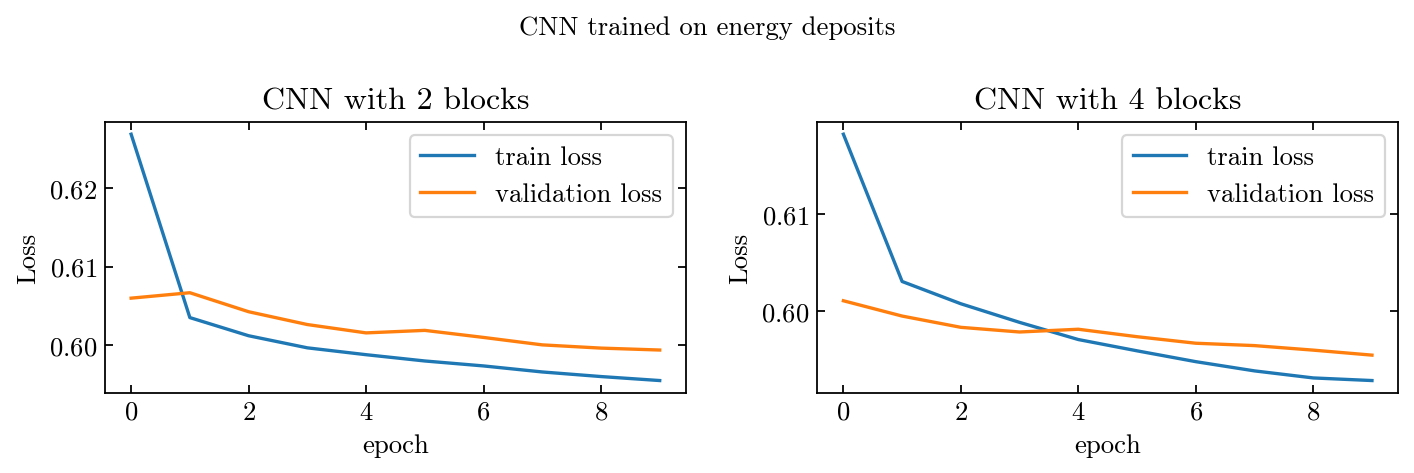

In [21]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
plt.plot(range(len(cnn_energy_outputs['train_loss'])), cnn_energy_outputs['train_loss'], label='train loss')
plt.plot(range(len(cnn_energy_outputs['val_loss'])), cnn_energy_outputs['val_loss'], label='validation loss')
plt.title('CNN with 2 blocks')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')
# plt.ylim(0.575, 0.655)

plt.subplot(1, 2, 2)
plt.plot(range(len(cnn_energy_outputs['4_layers_train_loss'])), cnn_energy_outputs['4_layers_train_loss'], label='train loss')
plt.plot(range(len(cnn_energy_outputs['4_layers_val_loss'])), cnn_energy_outputs['4_layers_val_loss'], label='validation loss')
plt.title('CNN with 4 blocks')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')

plt.suptitle('CNN trained on energy deposits', fontsize=12)
plt.tight_layout()
plt.show()

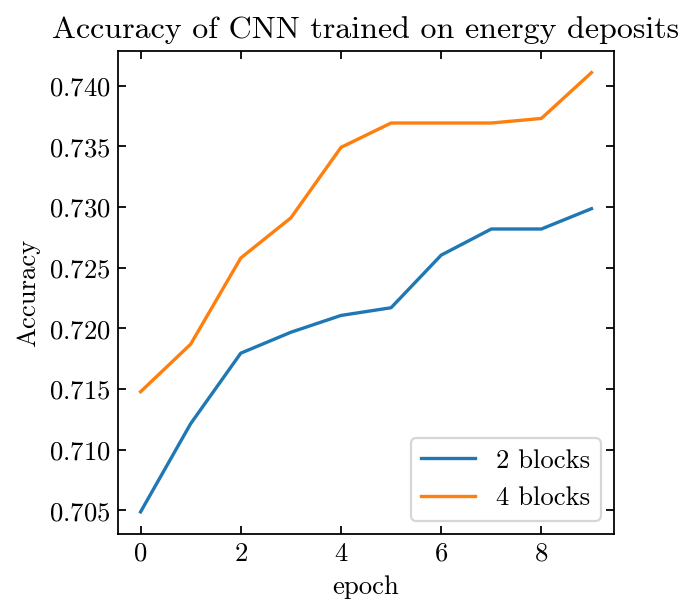

In [23]:
plt.plot(range(len(cnn_energy_outputs['val_best_auc'])), cnn_energy_outputs['val_best_auc'], label='2 blocks')
plt.plot(range(len(cnn_energy_outputs['4_layers_val_best_auc'])), cnn_energy_outputs['4_layers_val_best_auc'], label='4 blocks')
plt.title('Accuracy of CNN trained on energy deposits')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

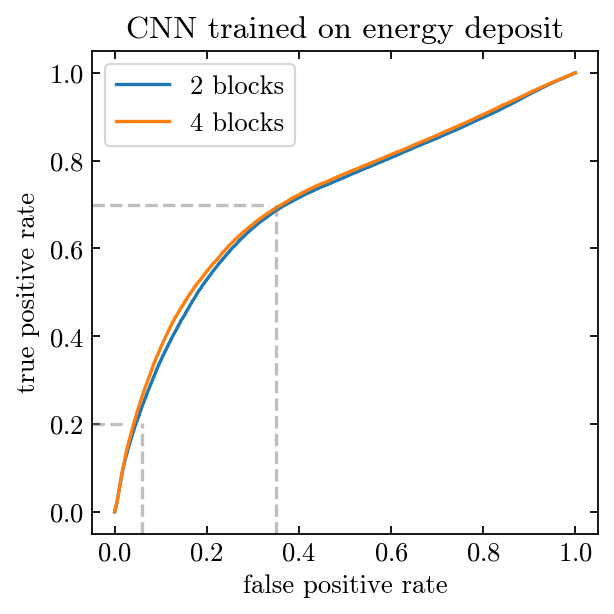

In [24]:
plt.plot(cnn_energy_outputs['val_fpr'], cnn_energy_outputs['val_tpr'], label='2 blocks')
plt.plot(cnn_energy_outputs['4_layers_val_fpr'], cnn_energy_outputs['4_layers_val_tpr'], label='4 blocks')
plt.title('CNN trained on energy deposit')
plt.legend()

plt.axvline(0.06, ymax=0.23, color='gray', ls='--', alpha=0.5)## vertical line
plt.axvline(0.35, ymax=0.68, color='gray', ls='--', alpha=0.5)## vertical line
plt.axhline(0.7, xmax=0.35, color='gray', ls='--', alpha=0.5)## horizontal line
plt.axhline(0.2, xmax=0.06, color='gray', ls='--', alpha=0.5)## horizontal line

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

plt.tight_layout()
plt.show()

## ResNet

In [26]:
# load model

PATH = '../EGamma/saves/cnn_saved_at_20_resblocks_3.pth'
ckpt_3 = torch.load(PATH, map_location=torch.device('cpu'))

PATH = '../EGamma/saves/cnn_saved_at_20_resblocks_5.pth'
ckpt_5 = torch.load(PATH, map_location=torch.device('cpu'))

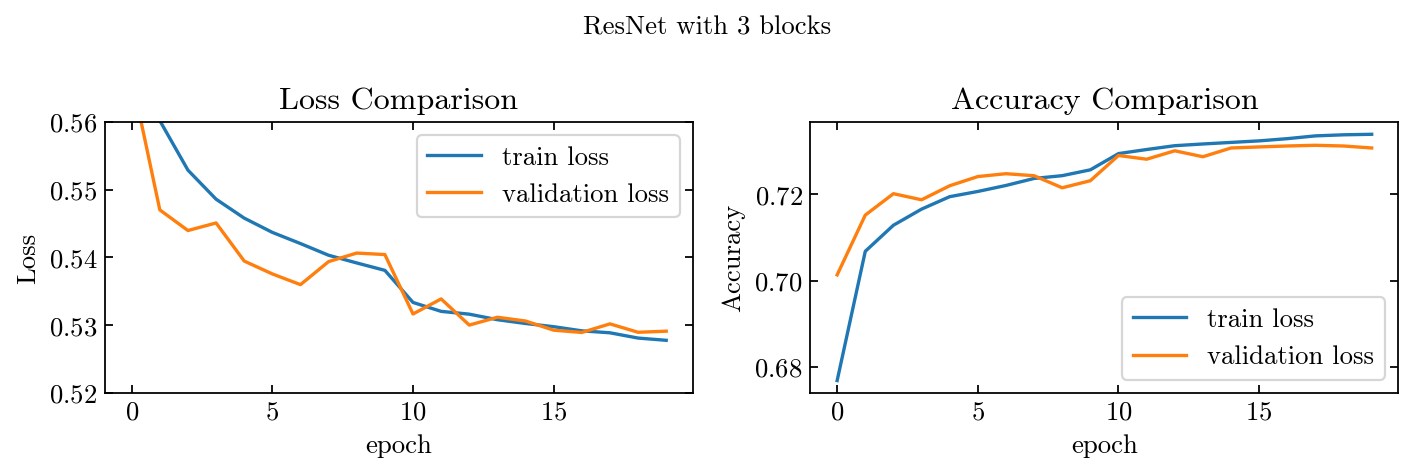

In [24]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
plt.plot(range(len(ckpt_3['train_loss'])), ckpt_3['train_loss'], label='train loss')
plt.plot(range(len(ckpt_3['val_loss'])), ckpt_3['val_loss'], label='validation loss')
plt.title('Loss Comparison')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.ylim(0.52, 0.56)

plt.subplot(1, 2, 2)
plt.plot(range(len(ckpt_3['train_acc'])), ckpt_3['train_acc'], label='train loss')
plt.plot(range(len(ckpt_3['val_acc'])), ckpt_3['val_acc'], label='validation loss')
plt.title('Accuracy Comparison')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy')

plt.suptitle('ResNet with 3 blocks', fontsize=12)
plt.tight_layout()
plt.show()

--------------------------------------------------
The best AUC score for 3 blocks is 0.789
The best AUC score for 5 blocks is 0.791
--------------------------------------------------


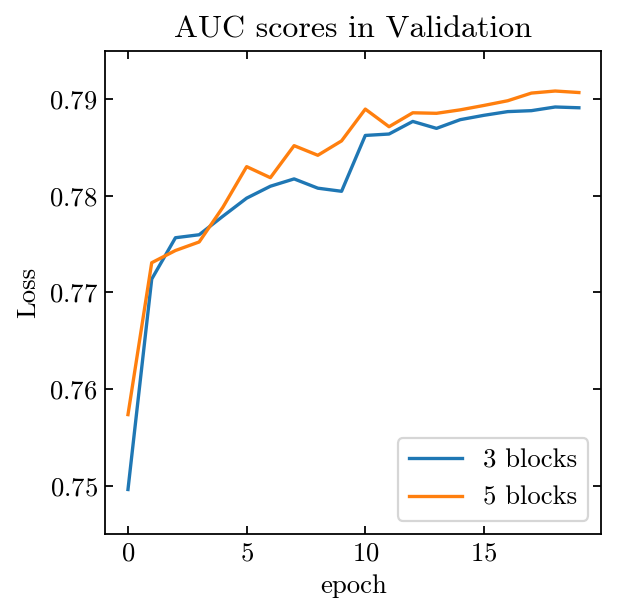

In [46]:
plt.plot(range(len(ckpt_3['val_auc'])), ckpt_3['val_auc'], label='3 blocks')
plt.plot(range(len(ckpt_5['val_auc'])), ckpt_5['val_auc'], label='5 blocks')
plt.title('AUC scores in Validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.ylim(0.745, 0.795)

print('-'*50)
print('The best AUC score for 3 blocks is {:.3f}'.format(max(ckpt_3['val_auc'])))
print('The best AUC score for 5 blocks is {:.3f}'.format(max(ckpt_5['val_auc'])))
print('-'*50)

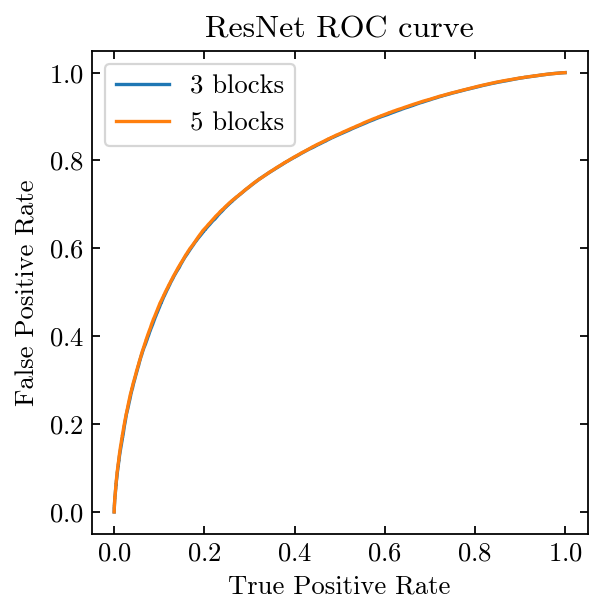

In [48]:
plt.plot(ckpt_3['fpr'][0], ckpt_3['tpr'][0], label='3 blocks')
plt.plot(ckpt_5['fpr'][0], ckpt_5['tpr'][0], label='5 blocks')
plt.title('ResNet ROC curve')
plt.legend()
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
plt.show()